<a href="https://colab.research.google.com/github/furrutiav/labs-edpn/blob/main/Laboratorio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra  
**Integrantes:** Felipe Urrutia, Daniel Minaya, Sebastian Toloza

In [1]:
try:
    import google.colab  # noqa: F401
except ImportError:
    from dolfinx import *
else:
  try:
      from dolfinx import *
  except ImportError:
      !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
      from dolfinx import *

!pip install -q gmsh

--2022-05-01 20:56:31--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3055 (3.0K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-05-01 20:56:31 (38.4 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [3055/3055]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/60fe1e0/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/60fe1e0/releases/pybind11-install.sh == http* ]]


In [2]:
!pip install -q piglet pyvirtualdisplay
!pip install -q pyvista
!apt-get -qq install xvfb

     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 1.4 MB 34.4 MB/s 


In [3]:
import ufl
import gmsh
import pyvista
import numpy as np
import sys
from mpi4py import MPI
from dolfinx import io
from dolfinx import cpp
from dolfinx import fem
from dolfinx import mesh
from dolfinx import plot
from petsc4py import PETSc
import matplotlib.pyplot as plt
from petsc4py.PETSc import ScalarType

from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

%matplotlib inline
pyvista.OFF_SCREEN=False
pyvista.set_jupyter_backend("static")

# E1

### Definición del dominio

In [ ]:
#Primero, inicializar gmsh
gmsh.initialize()

#Parametros de la geometría
a, b = 0, 0
r = 0.5
gdim = 2

#Elementos básicos
square = gmsh.model.occ.addRectangle(-1,-1,0, 2, 2)
circle = gmsh.model.occ.addDisk(a, b, 0, r, r)

#"Restando" dominios
domain = gmsh.model.occ.cut([(gdim, square)], [(gdim, circle)])
gmsh.model.occ.synchronize()

#Definiendo la parte del dominio en la que se define la solución
volumes = gmsh.model.getEntities(dim=gdim)
status = gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]])

#Fijando parametros de la grilla y generándola
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)
gmsh.model.mesh.generate(gdim)

In [ ]:
#Todo lo de esta celda sirve para pasar la malla desde gmsh hasta dolphinx
#solo importa si van a trabajar con multiprocesos, pero hay que correrlo igual.

if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    geometry_data = io.extract_gmsh_geometry(gmsh.model)
    # Get mesh topology for each element
    topology_data = io.extract_gmsh_topology_and_markers(gmsh.model)

# Extract the cell type and number of nodes per cell and broadcast
# it to the other processors 
if MPI.COMM_WORLD.rank == 0:
    # Extract the cell type and number of nodes per cell and broadcast
    # it to the other processors 
    gmsh_cell_type = list(topology_data.keys())[0]    
    properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
    name, dim, order, num_nodes, local_coords, _ = properties
    cells = topology_data[gmsh_cell_type]["topology"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([gmsh_cell_type, num_nodes], root=0)
else:        
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

# Permute topology data from MSH-ordering to dolfinx-ordering
ufl_domain = io.ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = io.cell_perm_gmsh(cpp.mesh.to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]

In [ ]:
# Generando el dominio
domain = mesh.create_mesh(MPI.COMM_WORLD, cells, geometry_data[:, :gdim], ufl_domain)
V = fem.FunctionSpace(domain, ("CG", 1))

def boundary_circle(x):
    return np.isclose( x[0]**2 + x[1]**2 - 0.5**2, 0)

def boundary_square_h(x):
    return np.isclose(abs(x[1]), 1)

def boundary_square_v(x):
    return np.isclose(abs(x[0]), 1)


dofs_circle = fem.locate_dofs_geometrical(V, boundary_circle)
dofs_h = fem.locate_dofs_geometrical(V, boundary_square_h)
dofs_v = fem.locate_dofs_geometrical(V, boundary_square_v)

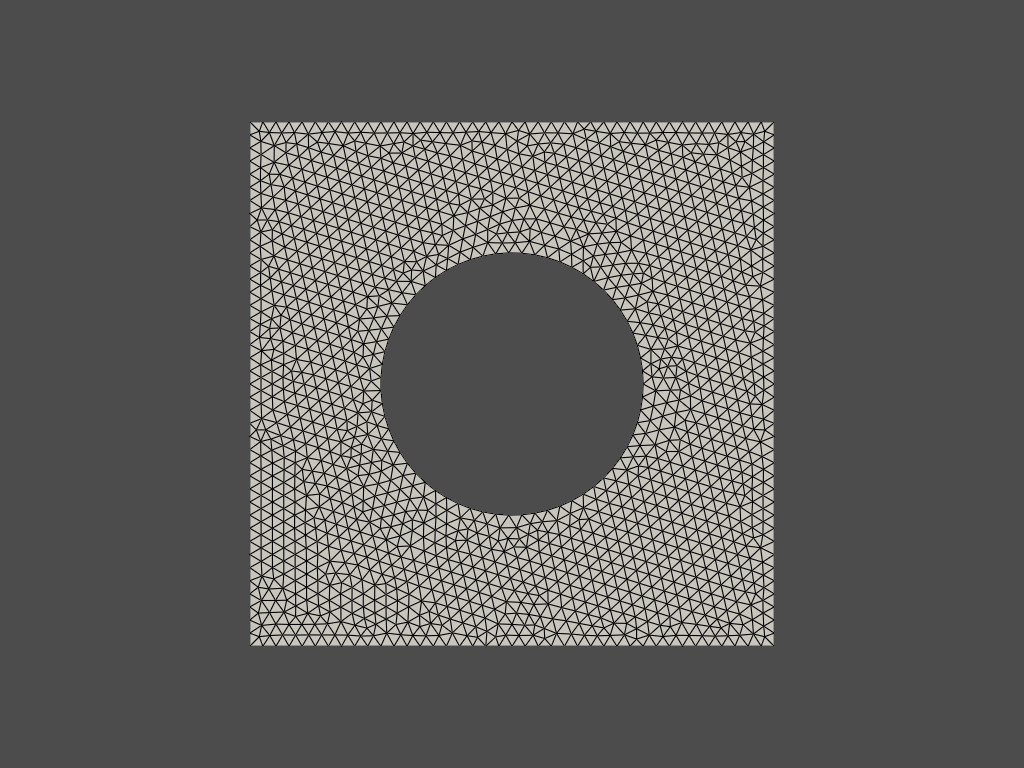

In [ ]:
#Graficamos para ver si definimos bien el dominio
tdim = domain.topology.dim
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()

### Datos del problema

In [ ]:
zero = fem.Function(V)
zero.interpolate(lambda x: x[0]*0.0)

fun1 = fem.Function(V)
fun1.interpolate(lambda x: 200 * (1-x[0]*x[0]))

### Condiciones de borde

In [ ]:
bc_circle = fem.dirichletbc(zero, dofs_circle)
bc_h = fem.dirichletbc(fun1, dofs_h)
bc_v = fem.dirichletbc(zero, dofs_v)

bcs = [bc_circle, bc_h, bc_v]

### Formulación variacional

In [ ]:
#Formulacion variacional
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, ScalarType(0.0))


a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

### Resolución y gráficos

In [ ]:
#Solucion
problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

#### Graficando la malla

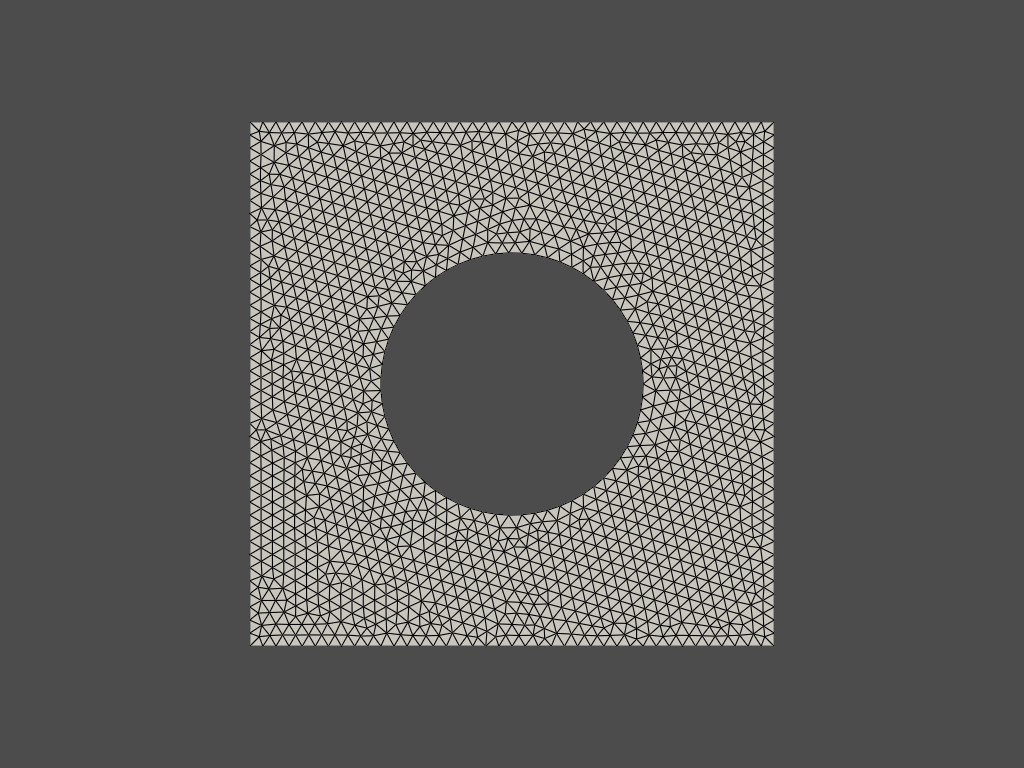

In [ ]:
#Extraemos información necesaria para graficar la grilla
tdim = domain.topology.dim
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

#Inicializamos el grafico
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()

#### Graficando la solución

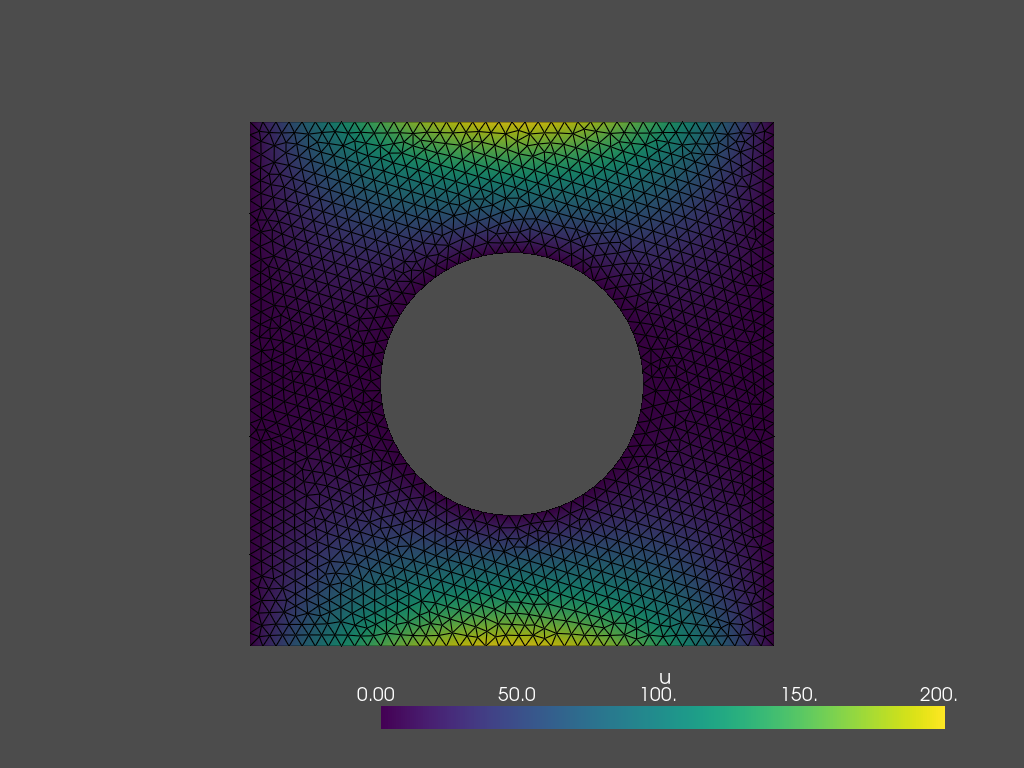

In [ ]:
#Extraemos información del espacio funcional para graficar la solución
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

#Creamos la grilla de la función a evaluar
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter(notebook = True) #Importante el argumento notebook
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()

u_plotter.show()

**Comentarios:** Esta bien! 🤗

# E2


## a


### Definición del dominio

In [ ]:
#Parametros de la geometría
a, b = 0, 0
r = 0.5
gdim = 2

#Elementos básicos
square = gmsh.model.occ.addRectangle(-1,-1,0, 2, 2)
circle = gmsh.model.occ.addDisk(a, b, 0, r, r)

#"Restando" dominios
domain = gmsh.model.occ.cut([(gdim, square)], [(gdim, circle)])
gmsh.model.occ.synchronize()

#Definiendo la parte del dominio en la que se define la solución
volumes = gmsh.model.getEntities(dim=gdim)
status = gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]])

#Fijando parametros de la grilla y generándola
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)
gmsh.model.mesh.generate(gdim)

In [ ]:
#Todo lo de esta celda sirve para pasar la malla desde gmsh hasta dolphinx
#solo importa si van a trabajar con multiprocesos, pero hay que correrlo igual.

if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    geometry_data = io.extract_gmsh_geometry(gmsh.model)
    # Get mesh topology for each element
    topology_data = io.extract_gmsh_topology_and_markers(gmsh.model)

# Extract the cell type and number of nodes per cell and broadcast
# it to the other processors 
if MPI.COMM_WORLD.rank == 0:
    # Extract the cell type and number of nodes per cell and broadcast
    # it to the other processors 
    gmsh_cell_type = list(topology_data.keys())[0]    
    properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
    name, dim, order, num_nodes, local_coords, _ = properties
    cells = topology_data[gmsh_cell_type]["topology"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([gmsh_cell_type, num_nodes], root=0)
else:        
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

# Permute topology data from MSH-ordering to dolfinx-ordering
ufl_domain = io.ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = io.cell_perm_gmsh(cpp.mesh.to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]

In [ ]:
# Generando el dominio
domain = mesh.create_mesh(MPI.COMM_WORLD, cells, geometry_data[:, :gdim], ufl_domain)
V = fem.FunctionSpace(domain, ("CG", 1))

def boundary_circle(x):
    return np.isclose( x[0]**2 + x[1]**2 - 0.5**2, 0)

def boundary_square_h(x):
    return np.isclose(abs(x[1]), 1)

def boundary_square_v(x):
    return np.isclose(abs(x[0]), 1)


dofs_circle = fem.locate_dofs_geometrical(V, boundary_circle)
dofs_h = fem.locate_dofs_geometrical(V, boundary_square_h)
dofs_v = fem.locate_dofs_geometrical(V, boundary_square_v)

### Datos del problema

In [ ]:
zero = fem.Function(V)
zero.interpolate(lambda x: x[0]*0.0)

fun1 = fem.Function(V)
fun1.interpolate(lambda x: 200 * (1-x[0]*x[0]))

### Condiciones de borde

In [ ]:
bc_h = fem.dirichletbc(fun1, dofs_h)
bc_v = fem.dirichletbc(zero, dofs_v)

bcs = [bc_h, bc_v]

### Formulación variacional

In [ ]:
#Formulacion variacional
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, ScalarType(0.0))


a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

### Resolución y gráficos

In [ ]:
#Solucion
problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

#### Graficando la malla

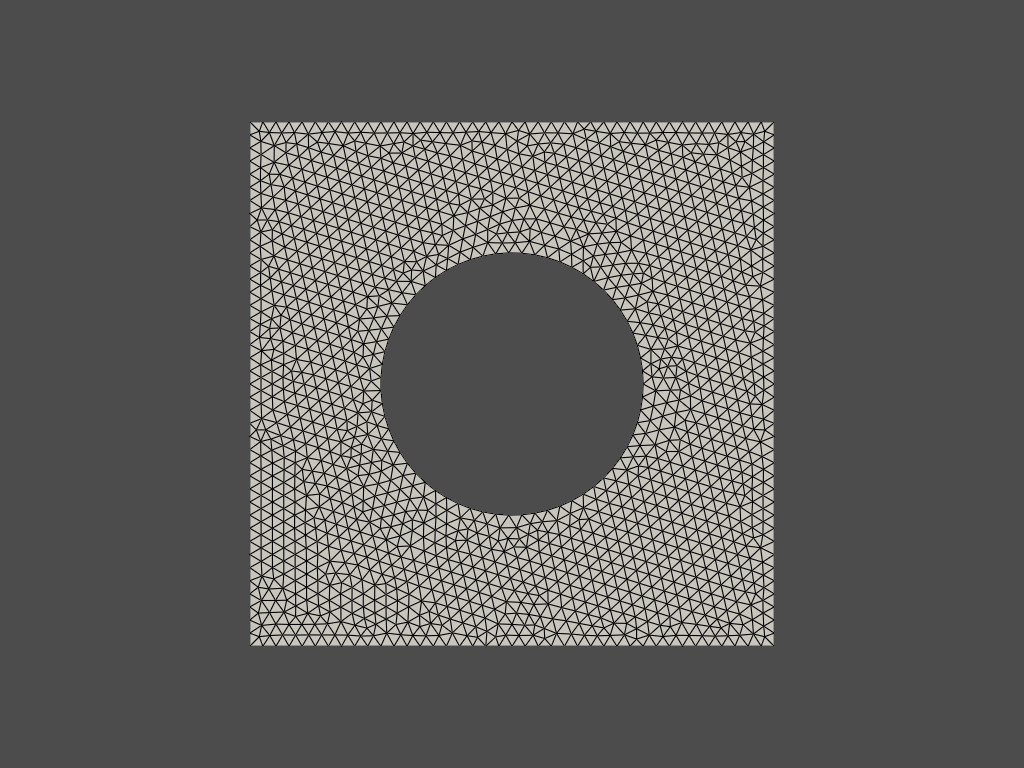

In [ ]:
#Extraemos información necesaria para graficar la grilla
tdim = domain.topology.dim
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

#Inicializamos el grafico
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()

#### Graficando la solución

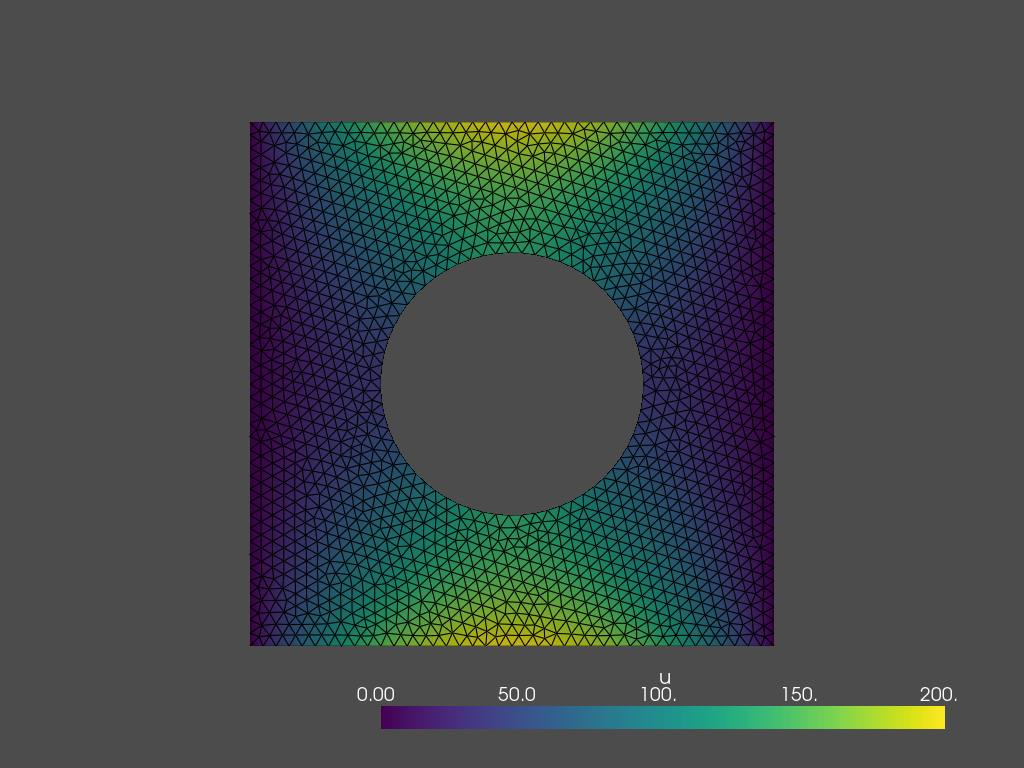

In [ ]:
#Extraemos información del espacio funcional para graficar la solución
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

#Creamos la grilla de la función a evaluar
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter(notebook = True) #Importante el argumento notebook
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()

u_plotter.show()

**Comentarios:** Esta bien! 🤗

## b

In [ ]:
def solve(a=0, b=0, r=0.5, lmin=0.05, lmax=0.05, a1=1, bgrid=True): 
  #Primero, inicializar gmsh
  gmsh.initialize(sys.argv)


  #Parametros de la geometría
  gdim = 2

  #Elementos básicos
  square = gmsh.model.occ.addRectangle(-1,-1,0, 2, 2)
  circle = gmsh.model.occ.addDisk(a, b, 0, r, r)


  #"Restando" dominios
  domain = gmsh.model.occ.cut([(gdim, square)], [(gdim, circle)])
  gmsh.model.occ.synchronize()


  #Definiendo la parte del dominio en la que se define la solución
  volumes = gmsh.model.getEntities(dim=gdim)
  status = gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]])


  #Fijando parametros de la grilla y generándola
  gmsh.option.setNumber("Mesh.CharacteristicLengthMin",lmin)
  gmsh.option.setNumber("Mesh.CharacteristicLengthMax",lmax)
  gmsh.model.mesh.generate(gdim)


  #Todo lo de esta celda sirve para pasar la malla desde gmsh hasta dolphinx
  #solo importa si van a trabajar con multiprocesos, pero hay que correrlo igual.
  if MPI.COMM_WORLD.rank == 0:
      # Get mesh geometry
      geometry_data = io.extract_gmsh_geometry(gmsh.model)
      # Get mesh topology for each element
      topology_data = io.extract_gmsh_topology_and_markers(gmsh.model)

  # Extract the cell type and number of nodes per cell and broadcast
  # it to the other processors 
  if MPI.COMM_WORLD.rank == 0:
      # Extract the cell type and number of nodes per cell and broadcast
      # it to the other processors 
      gmsh_cell_type = list(topology_data.keys())[0]    
      properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
      name, dim, order, num_nodes, local_coords, _ = properties
      cells = topology_data[gmsh_cell_type]["topology"]
      cell_id, num_nodes = MPI.COMM_WORLD.bcast([gmsh_cell_type, num_nodes], root=0)
  else:        
      cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
      cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

  # Permute topology data from MSH-ordering to dolfinx-ordering
  ufl_domain = io.ufl_mesh_from_gmsh(cell_id, gdim)
  gmsh_cell_perm = io.cell_perm_gmsh(cpp.mesh.to_type(str(ufl_domain.ufl_cell())), num_nodes)
  cells = cells[:, gmsh_cell_perm]

  # Generando el dominio
  domain = mesh.create_mesh(MPI.COMM_WORLD, cells, geometry_data[:, :gdim], ufl_domain)
  V = fem.FunctionSpace(domain, ("CG", 1))

  def boundary_circle(x):
      return np.isclose((x[0]-a)**2 + (x[1]-b)**2 - r**2, 0)

  def boundary_square_h(x):
      return np.isclose(abs(x[1]), 1)

  def boundary_square_v(x):
      return np.isclose(abs(x[0]), 1)


  dofs_circle = fem.locate_dofs_geometrical(V, boundary_circle)
  dofs_h = fem.locate_dofs_geometrical(V, boundary_square_h)
  dofs_v = fem.locate_dofs_geometrical(V, boundary_square_v)

  zero = fem.Function(V)
  zero.interpolate(lambda x: x[0]*0.0)

  fun1 = fem.Function(V)
  fun1.interpolate(lambda x: 200 * (1-x[0]*x[0]))

  bc_h = fem.dirichletbc(fun1, dofs_h)
  bc_v = fem.dirichletbc(zero, dofs_v)

  bcs = [bc_h, bc_v]

  #Formulacion variacional
  u = ufl.TrialFunction(V)
  v = ufl.TestFunction(V)
  f = fem.Constant(domain, ScalarType(0.0))

  a = a1 * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
  L = f * v * ufl.dx

  #Solucion
  problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
  uh = problem.solve()

  #Extraemos información necesaria para graficar la grilla
  tdim = domain.topology.dim
  topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
  grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

  #Extraemos información del espacio funcional para graficar la solución
  u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

  #Creamos la grilla de la función a evaluar
  u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
  u_grid.point_data["u"] = uh.x.array.real
  u_grid.set_active_scalars("u")
  u_plotter = pyvista.Plotter(notebook = True) #Importante el argumento notebook
  u_plotter.add_mesh(u_grid, show_edges=bgrid)
  u_plotter.view_xy()

  u_plotter.show()

  gmsh.finalize()


## c

c: (0, 0)


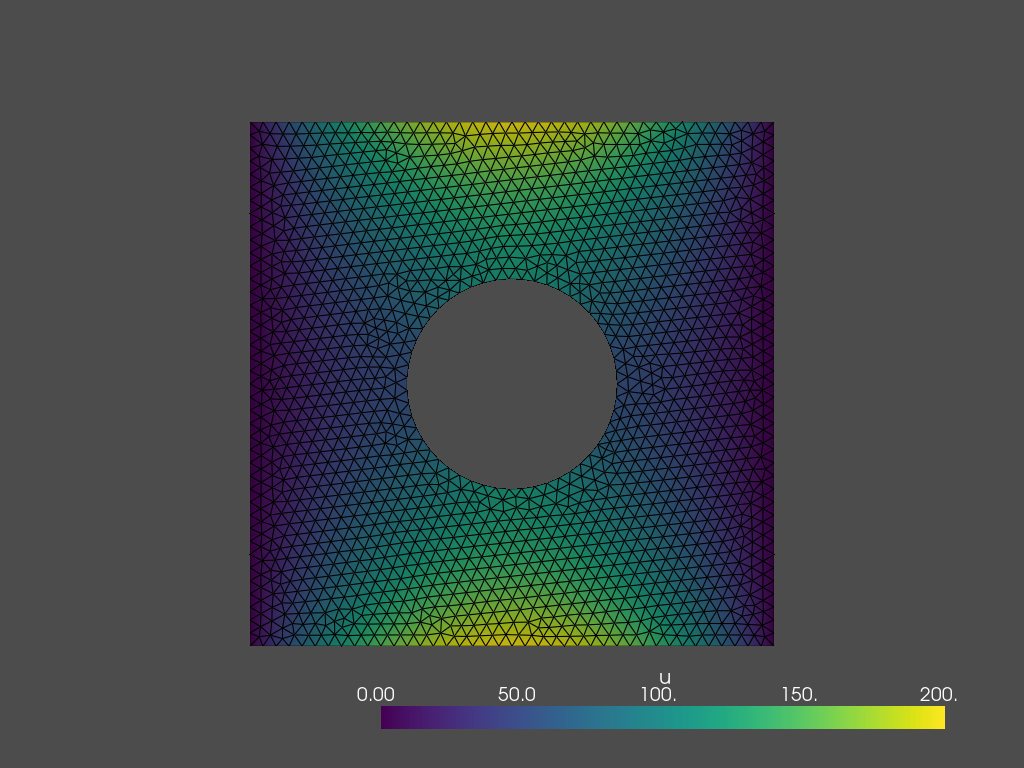

c: (0, 0.4)


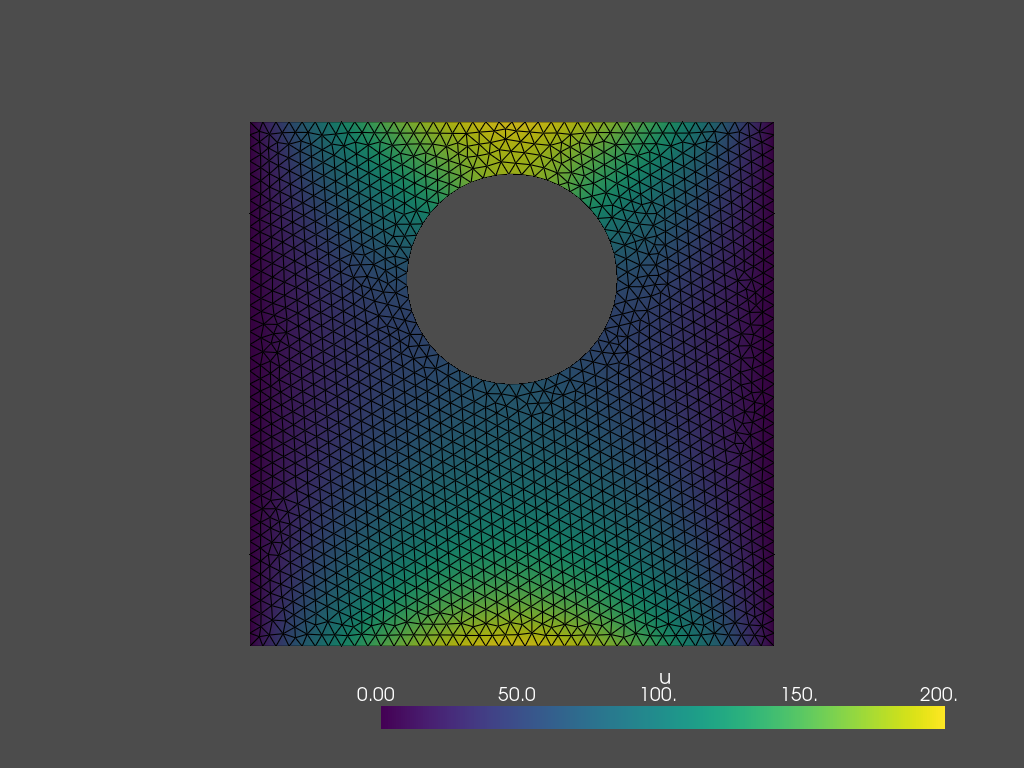

c: (0.4, 0.4)


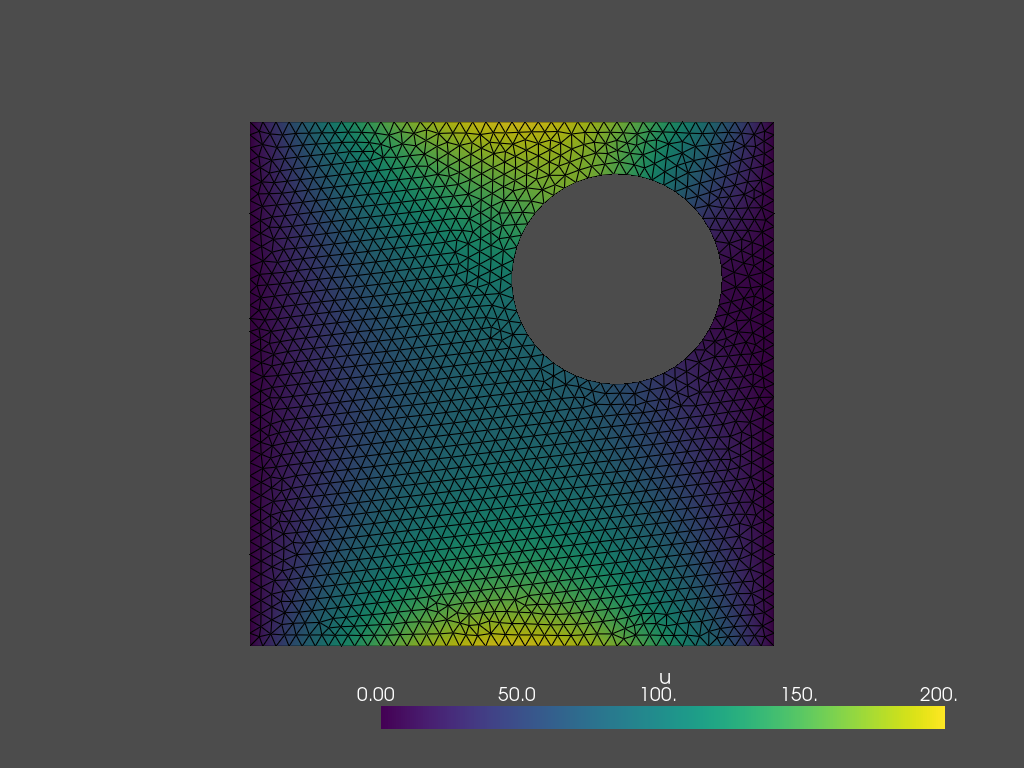

In [ ]:
r = 0.4
centers = [(0,0), (0,0.4), (0.4, 0.4)] 
for c in centers:
  print("c:", c)
  solve(a=c[0], b=c[1], r=r, lmin=0.05, lmax=0.05, a1=1)

r: 0.1


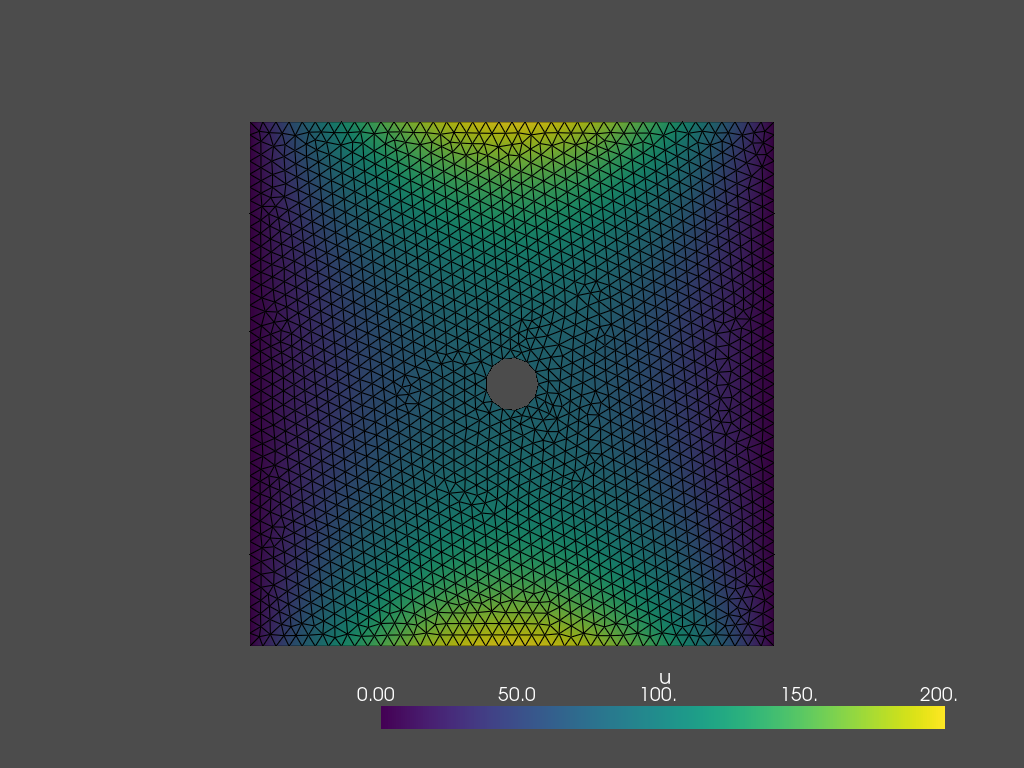

r: 0.5


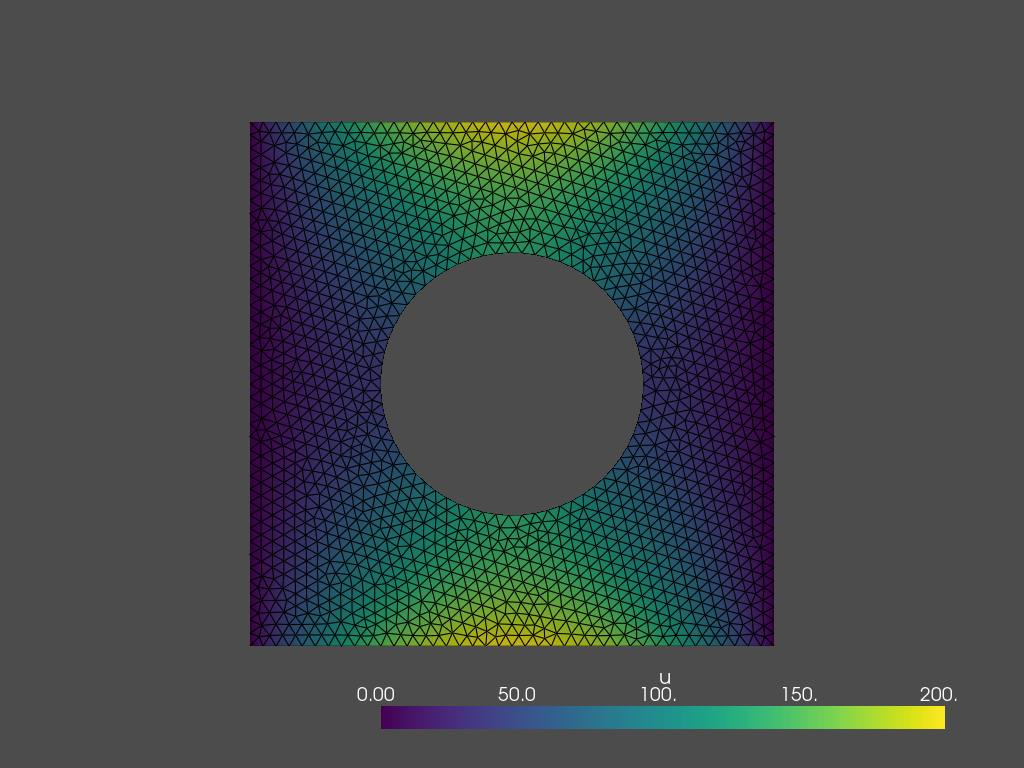

r: 0.9


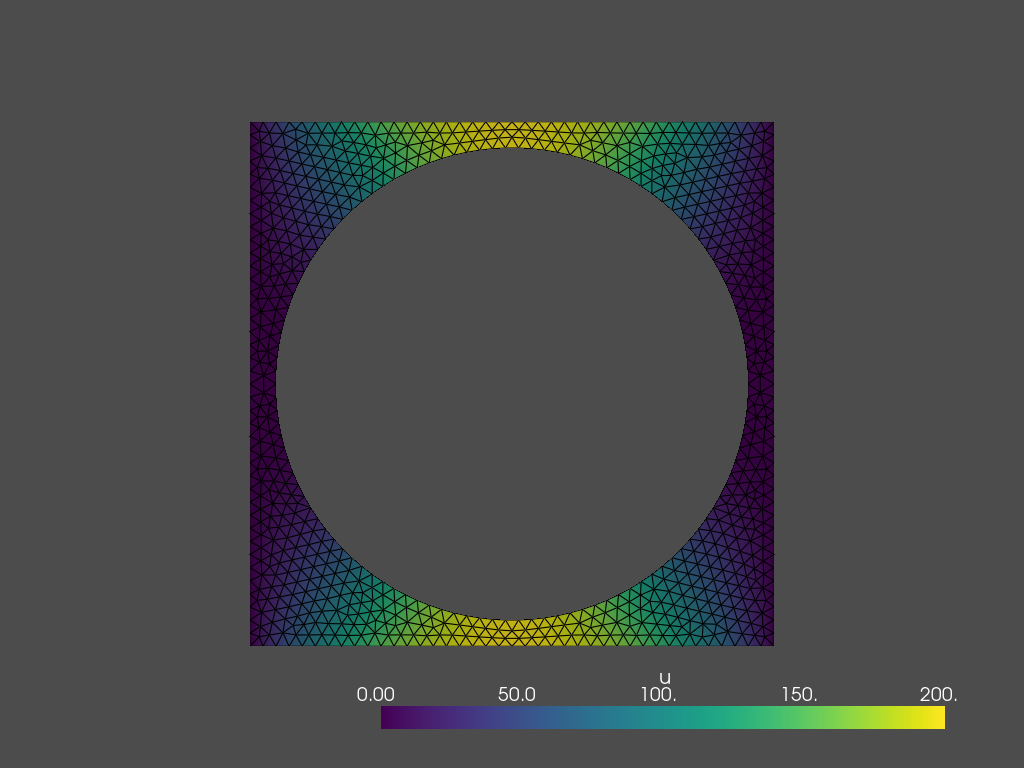

In [ ]:
c = 0,0
rs = [0.1, 0.5, 0.9]
for r in rs:
  print("r:", r)
  solve(a=c[0], b=c[1], r=r, lmin=0.05, lmax=0.05, a1=1)

l: 0.5


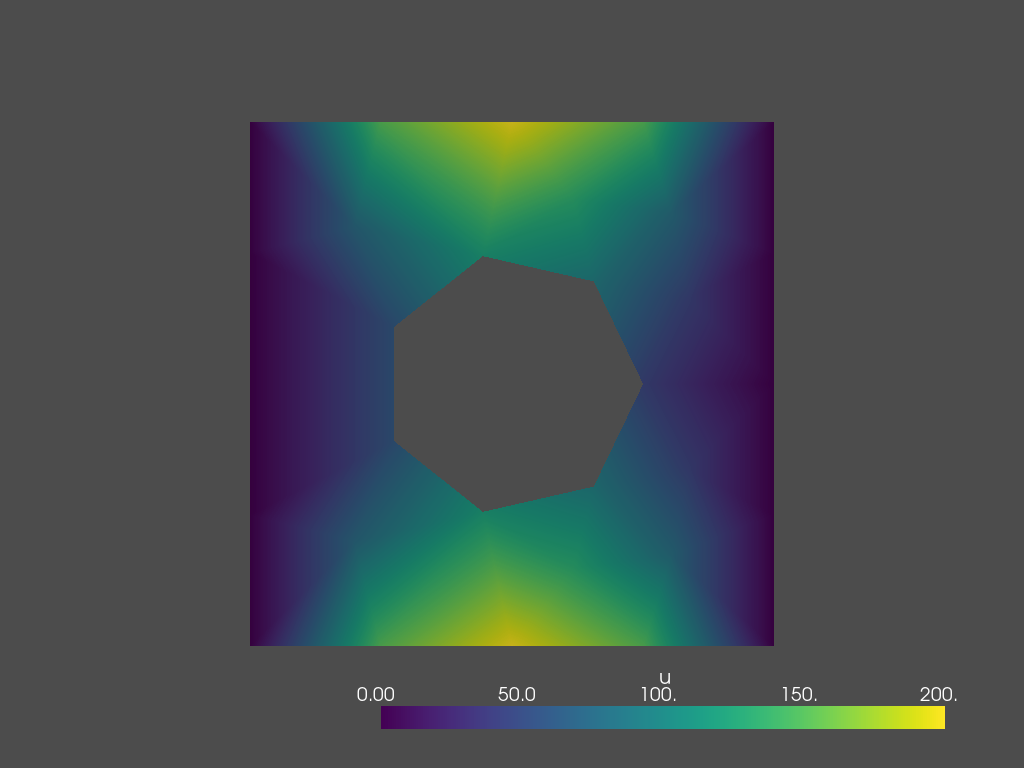

l: 0.1


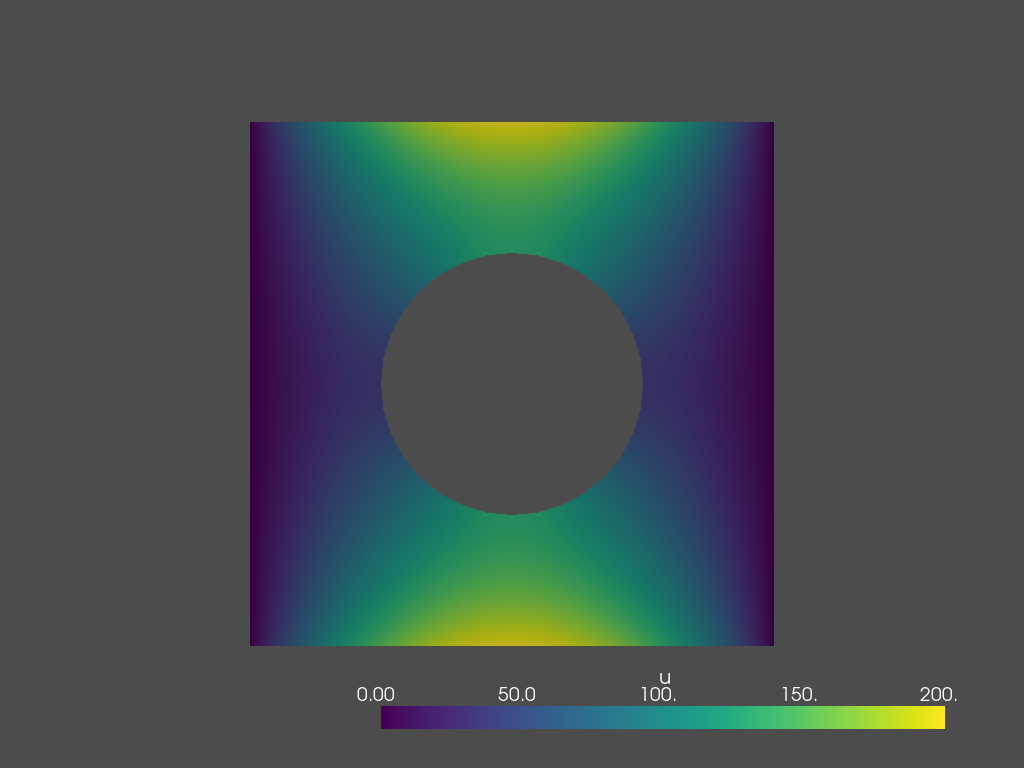

l: 0.05


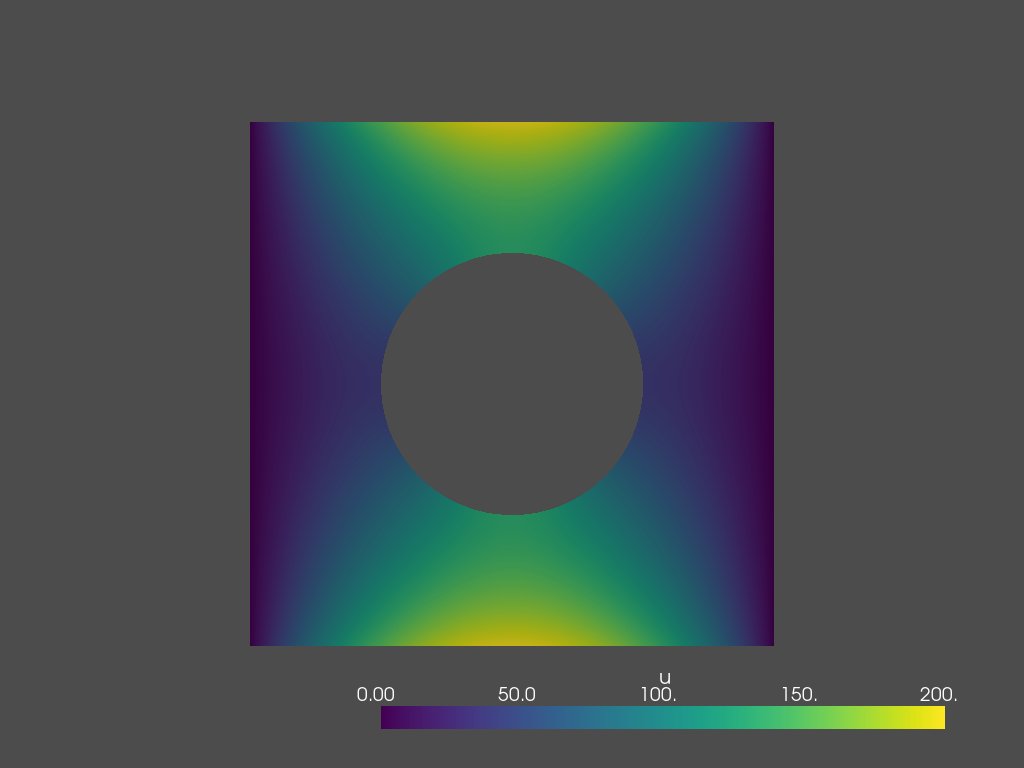

In [ ]:
c = 0,0
r = 0.5
ls = [0.5, 0.1, 0.05]
for l in ls:
  print("l:", l)
  solve(a=c[0], b=c[1], r=r, lmin=l, lmax=l, a1=1, bgrid=False)

# E3

In [4]:
def solve3(a=0, b=0, r=0.5, lmin=0.05, lmax=0.05, a1=1, a2=10, bgrid=True): 
  #Primero, inicializar gmsh
  gmsh.initialize(sys.argv)


  #Parametros de la geometría
  gdim = 2

  #Elementos básicos
  square = gmsh.model.occ.addRectangle(-1,-1,0, 2, 2)
  # circle = gmsh.model.occ.addDisk(a, b, 0, r, r)


  #"Restando" dominios
  # domain = gmsh.model.occ.cut([(gdim, square)], [(gdim, circle)])
  domain = square
  gmsh.model.occ.synchronize()


  #Definiendo la parte del dominio en la que se define la solución
  volumes = gmsh.model.getEntities(dim=gdim)
  status = gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]])


  #Fijando parametros de la grilla y generándola
  gmsh.option.setNumber("Mesh.CharacteristicLengthMin",lmin)
  gmsh.option.setNumber("Mesh.CharacteristicLengthMax",lmax)
  gmsh.model.mesh.generate(gdim)


  #Todo lo de esta celda sirve para pasar la malla desde gmsh hasta dolphinx
  #solo importa si van a trabajar con multiprocesos, pero hay que correrlo igual.
  if MPI.COMM_WORLD.rank == 0:
      # Get mesh geometry
      geometry_data = io.extract_gmsh_geometry(gmsh.model)
      # Get mesh topology for each element
      topology_data = io.extract_gmsh_topology_and_markers(gmsh.model)

  # Extract the cell type and number of nodes per cell and broadcast
  # it to the other processors 
  if MPI.COMM_WORLD.rank == 0:
      # Extract the cell type and number of nodes per cell and broadcast
      # it to the other processors 
      gmsh_cell_type = list(topology_data.keys())[0]    
      properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
      name, dim, order, num_nodes, local_coords, _ = properties
      cells = topology_data[gmsh_cell_type]["topology"]
      cell_id, num_nodes = MPI.COMM_WORLD.bcast([gmsh_cell_type, num_nodes], root=0)
  else:        
      cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
      cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

  # Permute topology data from MSH-ordering to dolfinx-ordering
  ufl_domain = io.ufl_mesh_from_gmsh(cell_id, gdim)
  gmsh_cell_perm = io.cell_perm_gmsh(cpp.mesh.to_type(str(ufl_domain.ufl_cell())), num_nodes)
  cells = cells[:, gmsh_cell_perm]

  # Generando el dominio
  domain = mesh.create_mesh(MPI.COMM_WORLD, cells, geometry_data[:, :gdim], ufl_domain)
  V = fem.FunctionSpace(domain, ("CG", 1))

  def boundary_square_h(x):
      return np.isclose(abs(x[1]), 1)

  def boundary_square_v(x):
      return np.isclose(abs(x[0]), 1)

  dofs_h = fem.locate_dofs_geometrical(V, boundary_square_h)
  dofs_v = fem.locate_dofs_geometrical(V, boundary_square_v)

  zero = fem.Function(V)
  zero.interpolate(lambda x: x[0]*0.0)

  fun1 = fem.Function(V)
  fun1.interpolate(lambda x: 200 * (1-x[0]*x[0]))

  bc_h = fem.dirichletbc(fun1, dofs_h)
  bc_v = fem.dirichletbc(zero, dofs_v)

  bcs = [bc_h, bc_v]

  #Formulacion variacional
  u = ufl.TrialFunction(V)
  v = ufl.TestFunction(V)
  f = fem.Constant(domain, ScalarType(0.0))
  

  A = fem.Function(V)

  def Ax(x):
    return a1+(a2-a1)*((x[0]-a)*(x[0]-a) + (x[1]-b)*(x[1]-b) <= r*r).astype(int)
    
  A.interpolate(Ax)

  a_F = A * ufl.dot(ufl.grad(u), ufl.grad(v))  * ufl.dx
  L = f * v * ufl.dx

  #Solucion
  problem = fem.petsc.LinearProblem(a_F, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
  uh = problem.solve()

  #Extraemos información necesaria para graficar la grilla
  tdim = domain.topology.dim
  topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
  grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

  #Extraemos información del espacio funcional para graficar la solución
  u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

  #Creamos la grilla de la función a evaluar
  u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
  u_grid.point_data["u"] = uh.x.array.real
  u_grid.set_active_scalars("u")
  u_plotter = pyvista.Plotter(notebook = True) #Importante el argumento notebook
  u_plotter.add_mesh(u_grid, show_edges=bgrid)
  u_plotter.view_xy()

  u_plotter.show()

  gmsh.finalize()


In [ ]:
gmsh.finalize()

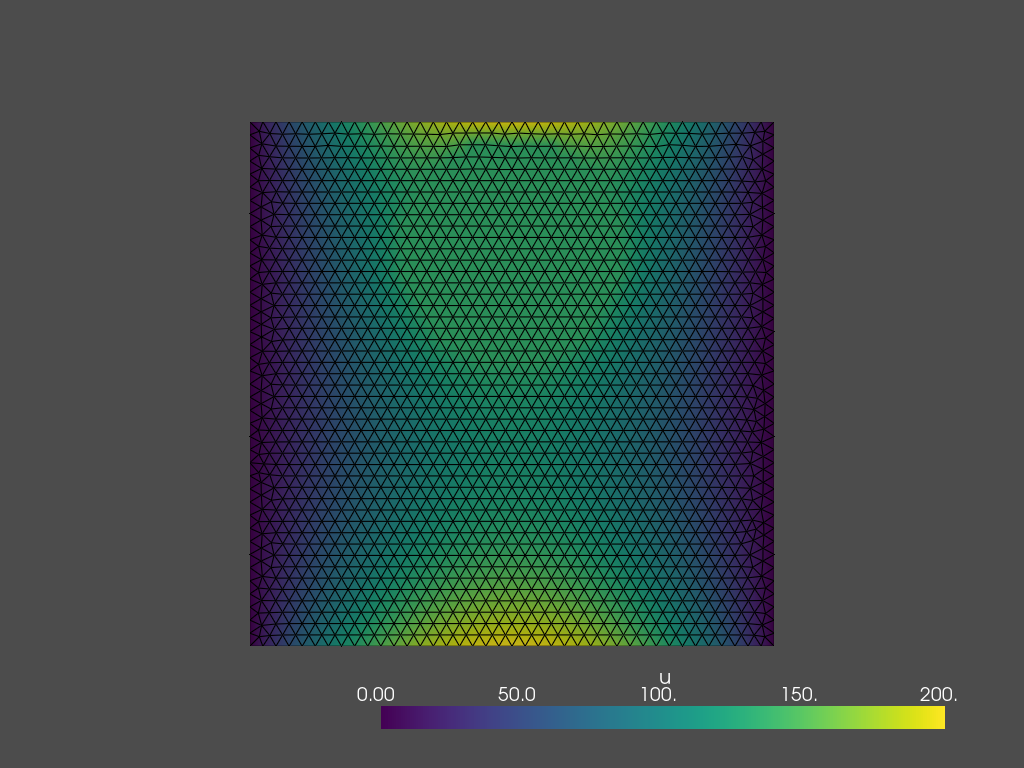

In [29]:
solve3(a=0, b=0.5, r=0.4, lmin=0.05, lmax=0.05, a1=1, a2=100000000, bgrid=True)